In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import os 

%matplotlib inline

def cv2_imshow(img):
    figsize(15,15)
    return plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [2]:
def to_hom(pts):
    return np.transpose(np.append(np.transpose(pts), [np.ones(len(pts))], axis=0))

# based on this implementation of normalization function in Matlab:
# https://github.com/PrimozGodec/machine-perception-ex5/blob/master/normalize2dpts.m
def normalize2dpts(pts):
    pts_hom = to_hom(pts)
    
    centroid_x, centroid_y, _ = np.mean(pts_hom, axis=0)
    newp_0 = pts_hom[:,0] - centroid_x 
    newp_1 = pts_hom[:,1] - centroid_y

    mean_dist = np.mean(np.sqrt(newp_0**2 + newp_1**2))
    
    scale = np.sqrt(2) / mean_dist
    
    T = [
        [scale, 0, -scale*centroid_x],
        [0, scale, -scale*centroid_y],
        [0, 0, 1],
    ]
    newpts = np.dot(T, np.transpose(pts_hom))    
    return newpts, T

def find_fund_matr(pts1, pts2):
    p_1, T_1 = normalize2dpts(pts1)
    p_2, T_2 = normalize2dpts(pts2)
    
    n = len(pts1)
    
    A = np.transpose([
        p_2[0]*p_1[0], 
        p_2[0]*p_1[1],
        p_2[0],
        p_2[1]*p_1[0],
        p_2[1]*p_1[1],
        p_2[1],
        p_1[0],
        p_1[1],
        np.ones(n)
    ])
    
    u, d, v = np.linalg.svd(A)
    
    smallest_r_eigvector = v[-1]
    F = smallest_r_eigvector.reshape(3,3)
    
    u, d, v = np.linalg.svd(F)
    F = u @ np.diag([d[0], d[1], 0]) @ v
    
    F = np.transpose(T_2) @ F @ T_1
    return F

In [3]:
def find_epilines(pts, image_in_pair, F):
    '''
    image_in_pair - image on which points pts are given
    lines are on another image in pair
    '''
    lines = []
    for p in pts:
        p = np.array([p[0], p[1], 1])
        if image_in_pair == 1:
            line = F @ p
        else:
            line = np.transpose(F) @ p
        lines.append(line)
    return np.array(lines)


In [4]:
# implementation for drawing lines is based on the function from the following tutorial:
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img_1, img_2, lines, pts_1, pts_2, colors):
    ''' img_1 - image on which we draw the epilines for the points in img2
        lines - array with coefficient [a, b, c] of corresponding epilines 
    '''
    _, w = img_1.shape
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_GRAY2BGR)
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_GRAY2BGR)
    
    for line, pt_1, pt_2, color in zip(lines, pts_1, pts_2, colors):
        a, b, c = line
        x_0, y_0 = map(int, [0, -c / b ])
        x_1, y_1 = map(int, [w, -(c + a * w)/ b ])
        img_1 = cv2.line(img_1, (x_0, y_0), (x_1, y_1), color, 1)
        img_1 = cv2.circle(img_1, tuple(pt_1), 5, color, -1)
        img_2 = cv2.circle(img_2, tuple(pt_2), 5, color, -1)
    return img_1, img_2

In [5]:
colors = [
    (255,0,0),
    (0,255,0),
    (0,0,255),
    (255,255,0),
    (0,255,255),
    (255,0,255),
    (255,140,0),
    (240, 140, 240)
]

# Images 1 & 2

In [100]:
img_1 = cv2.imread('./shc_1.jpg')
img_1_gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img_2 = cv2.imread('./shc_2.jpg')
img_2_gray = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

In [101]:
pts_1 = np.array([[279,142],
       [528,160],
       [526,202],
       [580,224],
       [280,282],
       [361,222],
       [203,125],
       [68,280]      
      ])

pts_2 =  np.array([
    [72,292],
    [496,81],
    [495,192],
    [597,192],
    [41,470],
    [316,341],
    [128,280],
    [30,482]
])

# Let's take a look at the points:

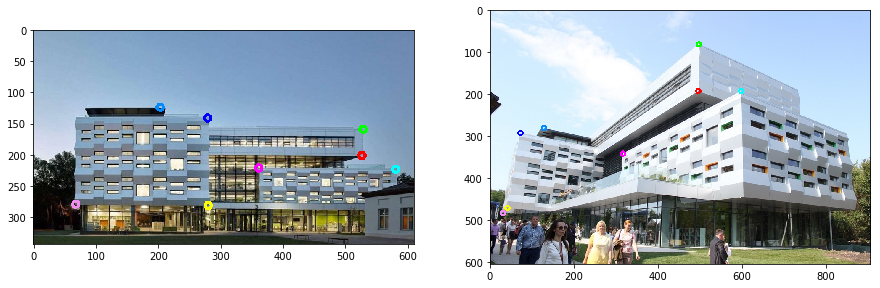

In [102]:
figsize(15,15)
im = img_1.copy()
for p, color in zip(pts_1, colors):
    im = cv2.circle(im, (p[0], p[1]), 5, color, 3)
plt.subplot(1,2,1)
cv2_imshow(im)

plt.subplot(1,2,2)
im = img_2.copy()
for p, color in zip(pts_2, colors):
    im = cv2.circle(im, (p[0], p[1]), 5, color, 3)
cv2_imshow(im);

# Now, let's find fundamental matrix and draw corresponding epilines:

In [103]:
pts_1 = np.int32(pts_1)
pts_2 = np.int32(pts_2)
F = find_fund_matr(pts_1, pts_2)

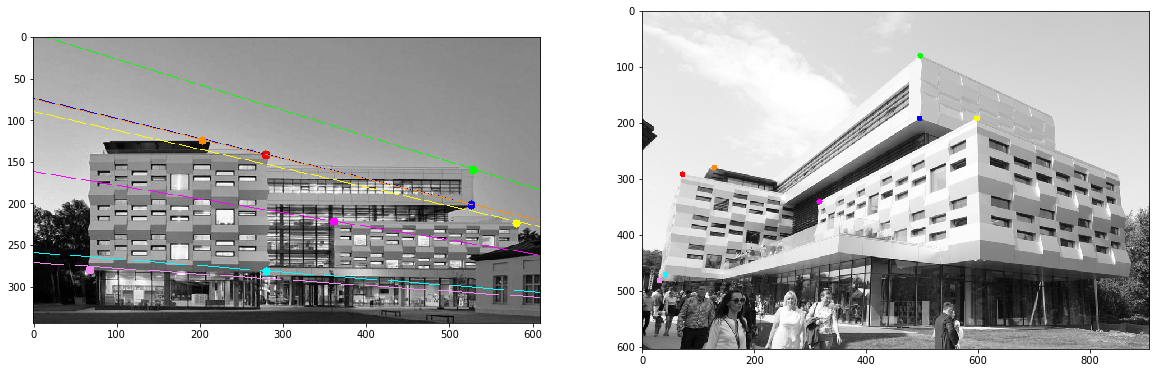

In [106]:
figsize(20,20)
lines_1 = find_epilines(pts_2, 2, F)
img_5, img_6 = drawlines(img_1_gray, img_2_gray, lines_1, pts_1, pts_2, colors)
plt.subplot(1,2,1)
plt.imshow(img_5)
plt.subplot(1,2,2)
plt.imshow(img_6)
plt.show()

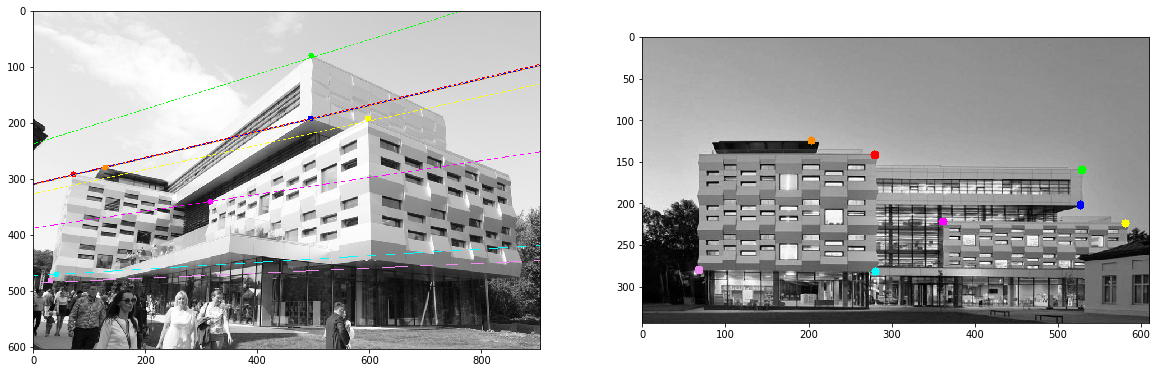

In [107]:
lines_2 = find_epilines(pts_1, 1,F)
img_3,img_4 = drawlines(img_2_gray, img_1_gray, lines_2, pts_2, pts_1, colors)
plt.subplot(1,2,1)
plt.imshow(img_3)
plt.subplot(1,2,2)
plt.imshow(img_4)
plt.show()

# We observe that results are reasonable.

----------------------------------------------------

# Images 1 & 3

In [108]:
img_1 = cv2.imread('./shc_1.jpg')
img_1_gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img_3 = cv2.imread('./shc_3.jpg')
img_3_gray = cv2.cvtColor(img_3, cv2.COLOR_BGR2GRAY)

pts_1 = np.array([
    [278,142],
    [282,226],
    [527,160],
    [526,202],
    [582,223],
    [360,252],
    [273,325],
    [562,216]      
])


pts_3 =  np.array([
    [89,282],
    [60,407],
    [703,4],
    [716,132],
    [936,100],
    [395,406],
    [79,574],
    [893,104]
])


# Let's take a look at points:

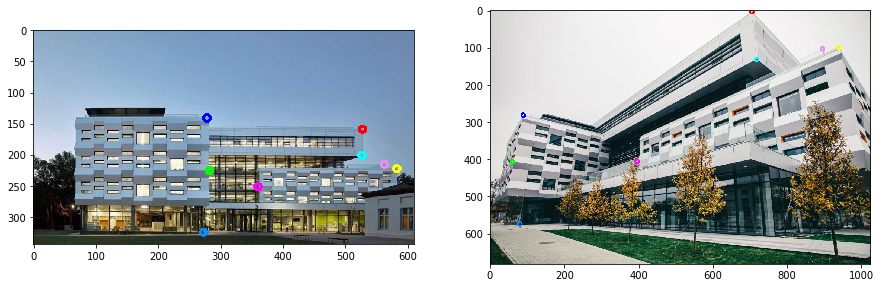

In [109]:
figsize(15,15)
im = img_1.copy()
for p, color in zip(pts_1, colors):
    im = cv2.circle(im, (p[0], p[1]), 5, color, 3)
plt.subplot(1,2,1)
cv2_imshow(im)

plt.subplot(1,2,2)
im = img_3.copy()
for p, color in zip(pts_3, colors):
    im = cv2.circle(im, (p[0], p[1]), 5, color, 3)
cv2_imshow(im);

# Now, let's find fundamental matrix and draw corresponding epilines:

In [110]:
pts_1 = np.int32(pts_1)
pts_3 = np.int32(pts_3)
F = find_fund_matr(pts_1, pts_3)

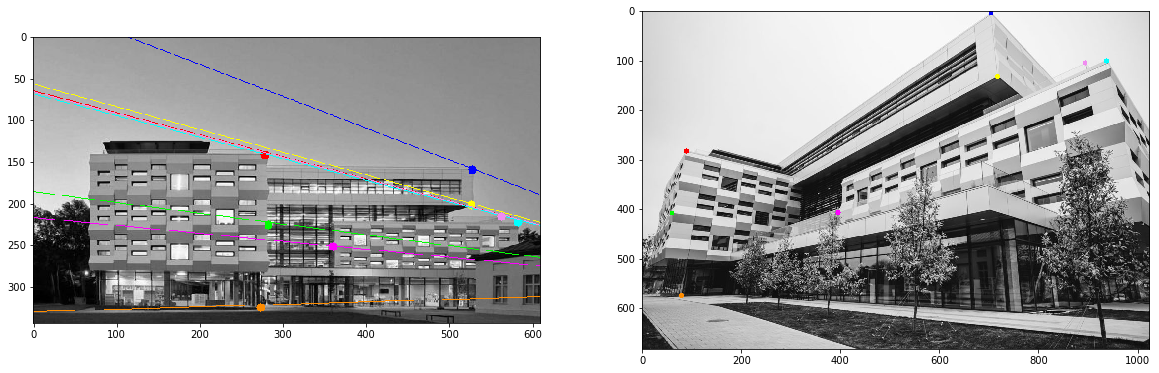

In [112]:
figsize(20,20)
lines_1 = find_epilines(pts_3, 2, F)
img_5, img_6 = drawlines(img_1_gray, img_3_gray, lines_1, pts_1, pts_3, colors)
plt.subplot(1,2,1)
plt.imshow(img_5)
plt.subplot(1,2,2)
plt.imshow(img_6)
plt.show()

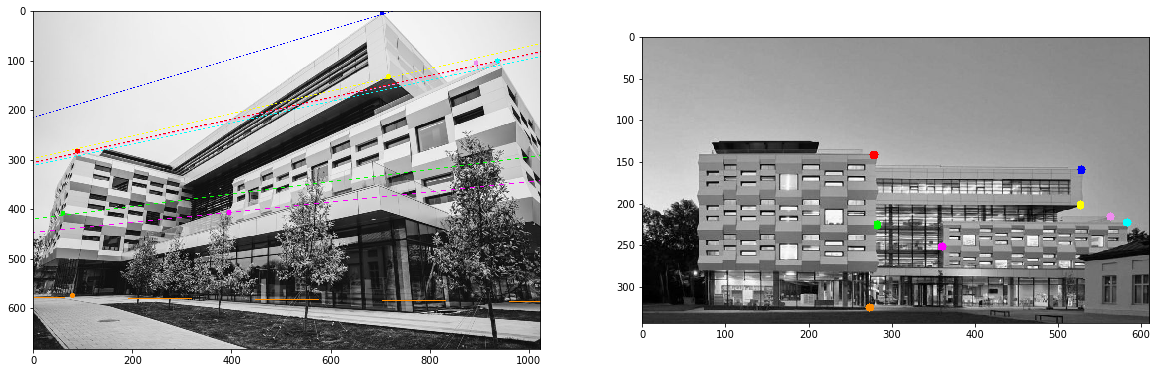

In [113]:
lines_2 = find_epilines(pts_1, 1,F)
img_3,img_4 = drawlines(img_3_gray, img_1_gray, lines_2, pts_3, pts_1, colors)
plt.subplot(1,2,1)
plt.imshow(img_3)
plt.subplot(1,2,2)
plt.imshow(img_4)
plt.show()

# We observe that results are reasonable, but some epilines overlaps.
-------------------------------

# Images 2 & 3

In [6]:
img_2 = cv2.imread('./shc_2.jpg')
img_2_gray = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
img_3 = cv2.imread('./shc_3.jpg')
img_3_gray = cv2.cvtColor(img_3, cv2.COLOR_BGR2GRAY)

pts_2 = np.array([
    [71,291],
    [50,397],
    [496,81],
    [495,192],
    [596,192],
    [307,400],
    [353,366],
    [254,328]      
])

pts_3 =  np.array([
    [89,282],
    [60,407],
    [703,4],
    [716,132],
    [936,100],
    [395,406],
    [683,303],
    [304,334]
])

# Let's take a look at points:

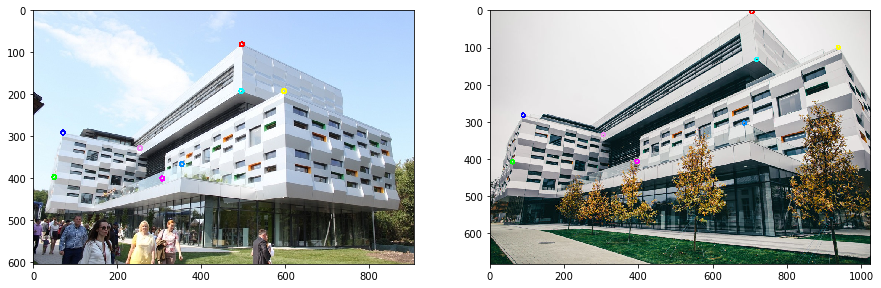

In [7]:
figsize(15,15)
im = img_2.copy()
for p, color in zip(pts_2, colors):
    im = cv2.circle(im, (p[0], p[1]), 5, color, 3)
plt.subplot(1,2,1)
cv2_imshow(im)

plt.subplot(1,2,2)
im = img_3.copy()
for p, color in zip(pts_3, colors):
    im = cv2.circle(im, (p[0], p[1]), 5, color, 3)
cv2_imshow(im);

# Now, let's find fundamental matrix and draw corresponding epilines:

In [8]:
pts_2 = np.int32(pts_2)
pts_3 = np.int32(pts_3)
F = find_fund_matr(pts_2, pts_3)

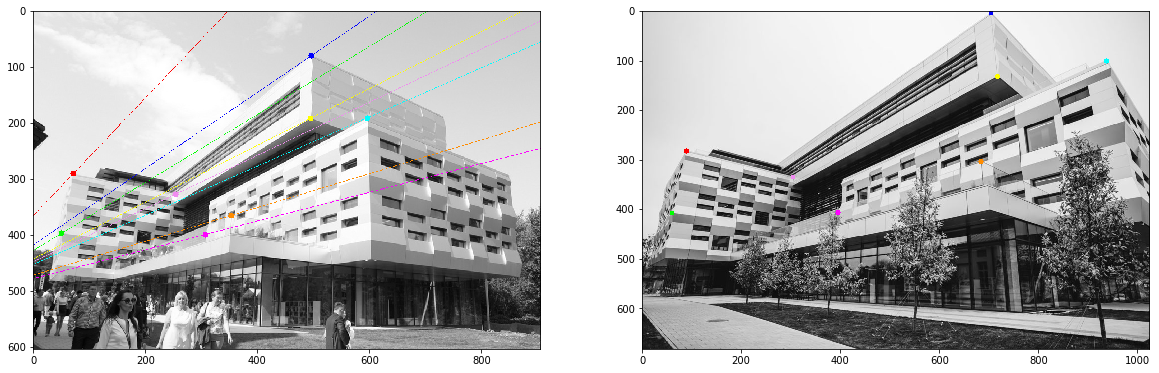

In [9]:
figsize(20,20)
lines_1 = find_epilines(pts_3, 2, F)
img_5, img_6 = drawlines(img_2_gray, img_3_gray, lines_1, pts_2, pts_3, colors)
plt.subplot(1,2,1)
plt.imshow(img_5)
plt.subplot(1,2,2)
plt.imshow(img_6)
plt.show()

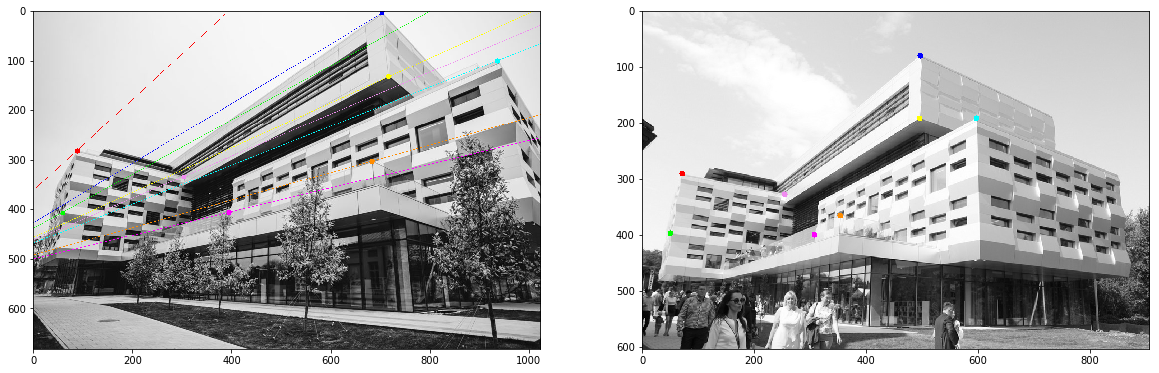

In [124]:
lines_2 = find_epilines(pts_2, 1, F)
img_3,img_4 = drawlines(img_3_gray, img_2_gray, lines_2, pts_3, pts_2, colors)
plt.subplot(1,2,1)
plt.imshow(img_3)
plt.subplot(1,2,2)
plt.imshow(img_4)
plt.show()

# We observe that results are reasonable, but not as good as in previous cases. Most likely, because of specific position change between 2 cameras (photos).